# 2D Poission density estimation using Gaussian Processes

This notebook contains the code for the blog post: https://sidravi1.github.io/blog/2018/08/22/poisson-density-estimation-with-gaussian-processes
It implements the Poisson regression in section 8.3 of Efron and Hastie's Computer Age Statistical Inference (CASI)

In [4]:
%matplotlib inline

In [5]:
import numpy as np
import pandas as pd
import theano
import theano.tensor as tt
import matplotlib.pyplot as plt
import pymc3 as pm
import seaborn as sns

import altair as alt

import scipy.stats.distributions as dist

from mpl_toolkits.mplot3d import Axes3D

## Get and reshape data

In [6]:
data = pd.read_csv("https://web.stanford.edu/~hastie/CASI_files/DATA/galaxy.txt", index_col=0, header=0, sep = " ")

In [7]:
col_labels = list(data.columns)
row_labels = list(data.index)

In [8]:
data.columns = np.arange(1, 16)
data.index = np.arange(18, 0, -1)
data_long = data.unstack().reset_index()
data_long.columns = ['r','m','val']
data_long['r2'] = data_long['r']**2
data_long['rm'] = data_long['r'] * data_long['m']
data_long['m2'] = data_long['m']**2
data_long['ones'] = 1

In [9]:
data_mat = data_long.drop('val', axis=1).values

In [440]:
data

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
18,1,6,6,3,1,4,6,8,8,20,10,7,16,9,4
17,3,2,3,4,0,5,7,6,6,7,5,7,6,8,5
16,3,2,3,3,3,2,9,9,6,3,5,4,5,2,1
15,1,1,4,3,4,3,2,3,8,9,4,3,4,1,1
14,1,3,2,3,3,4,5,7,6,7,3,4,0,0,1
13,3,2,4,5,3,6,4,3,2,2,5,1,0,0,0
12,2,0,2,4,5,4,2,3,3,0,1,2,0,0,1
11,4,1,1,4,7,3,3,1,2,0,1,1,0,0,0
10,1,0,0,2,2,2,1,2,0,0,0,1,2,0,0
9,1,1,0,2,2,2,0,0,0,0,1,0,0,0,0


In [224]:
data_long.head()

,r,m,val,r2,rm,m2,ones,latent,latent_sd,gp_latent,gp_latent_sd,linear_latent,linear_latent_sd,gp_dev,lin_dev,linear_yhat_mean,gp_yhat_mean
0,1,18,1,1,18,324,1,1.222646,1.267849,2.468660,1.340281,1.222646,1.267849,1.129969,0.043257,1.298,2.522
1,1,17,3,1,17,289,1,1.387396,1.223418,2.326463,1.263347,1.387396,1.223418,0.178505,1.401894,1.399,2.386
2,1,16,3,1,16,256,1,1.528688,1.192564,2.169394,1.236556,1.528688,1.192564,0.283775,1.102592,1.502,2.173
3,1,15,1,1,15,225,1,1.635518,1.173879,2.026433,1.239671,1.635518,1.173879,0.640311,0.287117,1.737,2.141
4,1,14,1,1,14,196,1,1.699066,1.165082,1.892060,1.252575,1.699066,1.165082,0.508788,0.337975,1.812,1.900


In [216]:
import codecs

with open("data_table.html", 'w') as f:
    f.write(data.to_html())
    

### Plot the data 
(similar to Fig 8.4 (left) in Efron and Hastie's CASI)

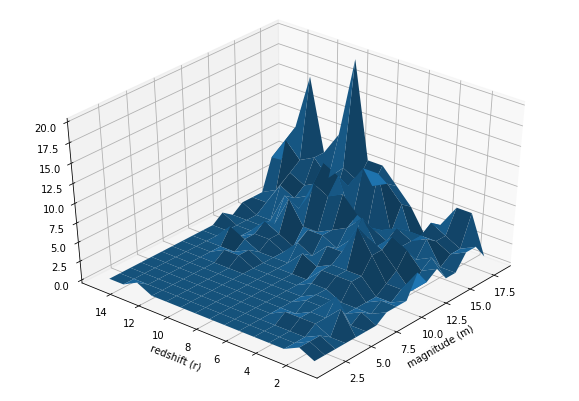

In [443]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(data.index, data.columns)
Z = data.values

surf = ax.plot_surface(X, Y, Z.T, linewidth=0, antialiased=True)
ax.set_xlabel("magnitude (m)")
ax.set_ylabel("redshift (r)")
ax.view_init(elev=40., azim=-140)

plt.savefig("/Users/sidravinutala/Documents/Sid files/sidravi1.github.io/assets/2018_08_22_data.png")

## With linear latent variable

We standardize the columns to mainly avoid overflow errors. Taking the `tt.exp` of the dot product can explode causing chains to die. 

In [13]:
data_mat_n = (data_mat - data_mat.mean(axis=0))/data_mat.std(axis=0) 
data_mat_n[:,-1] = 1

In [15]:
with pm.Model() as basic_model:
    
    alpha_0 = pm.Normal('alpha_0', 0, 10)
    alpha_1 = pm.Normal('alpha_1', 0, 10)
    alpha_2 = pm.Normal('alpha_2', 0, 10)
    alpha_3 = pm.Normal('alpha_3', 0, 10)
    alpha_4 = pm.Normal('alpha_4', 0, 10)
    alpha_5 = pm.Normal('alpha_5', 0, 10)
    
    latent = pm.Deterministic('latent', tt.dot(data_mat_n, tt.stack([alpha_0, alpha_1, alpha_2, alpha_3, alpha_4, alpha_5]))) 
    
    likelihood = pm.Poisson('like', tt.exp(latent), observed=data_long['val'].values)

In [16]:
trace = pm.sample(draws=1000, tune=1000, model=basic_model, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [alpha_5, alpha_4, alpha_3, alpha_2, alpha_1, alpha_0]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:14<00:00, 282.34draws/s]


Let's capture both the mean and the standard deviation.

In [28]:
data_long['linear_latent'] = np.exp(trace['latent'].mean(axis=0))
data_long['linear_latent_sd'] = np.exp(trace['latent'].std(axis=0))

In [29]:
latent_data = data_long.pivot('r','m','linear_latent')
latent_data_sd = data_long.pivot('r','m','linear_latent_sd')

### Plot the fitted distribution

In addition to replicating Fig 8.4 (right) in Efron and Hastie's CASI, I also include a plot of the standard deviation of the posterior draws.

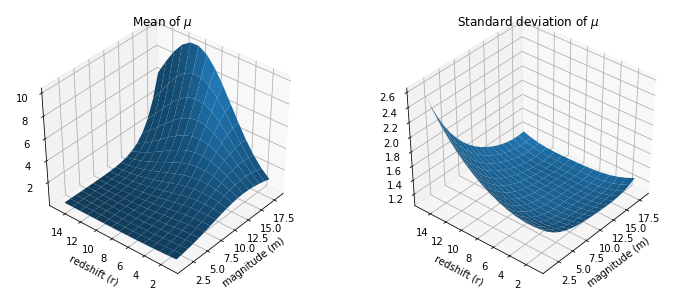

In [444]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121, projection='3d')
X, Y = np.meshgrid(latent_data.columns, latent_data.index)
Z = latent_data.values

surf = ax.plot_surface(X, Y, Z, linewidth=0, antialiased=True)
ax.view_init(elev=40., azim=-140)
ax.set_title(r"Mean of $\mu$")
ax.set_xlabel("magnitude (m)")
ax.set_ylabel("redshift (r)")

ax2 = fig.add_subplot(122, projection='3d')
X, Y = np.meshgrid(latent_data_sd.columns, latent_data_sd.index)
Z = latent_data_sd.values

surf = ax2.plot_surface(X, Y, Z, linewidth=0, antialiased=True)
ax2.view_init(elev=40., azim=-140)
ax2.set_title(r"Standard deviation of $\mu$",)
ax2.set_xlabel("magnitude (m)")
ax2.set_ylabel("redshift (r)")
plt.savefig("/Users/sidravinutala/Documents/Sid files/sidravi1.github.io/assets/2018_08_22_linear_model.png")

In [170]:
y_hats = pm.sample_ppc(trace, model=basic_model)
lin_yhat_means = y_hats['like'].mean(axis=0)
data_long['linear_yhat_mean'] = lin_yhat_means

100%|██████████| 1000/1000 [00:00<00:00, 1585.86it/s]


### Extending the domain

In [254]:
mean_vec = data_mat.mean(axis=0)
sd_vec = data_mat.std(axis=0) 

In [395]:
data_long[(data_long.r >= 8) & (data_long.r >= 8) & (data_long.m  >= 8) & (data_long.m >= 15)].head()

,r,m,val,r2,rm,m2,ones,latent,latent_sd,gp_latent,gp_latent_sd,linear_latent,linear_latent_sd,gp_dev,lin_dev,linear_yhat_mean,gp_yhat_mean
126,8,18,8,64,144,324,1,8.892114,1.095241,7.119818,1.155768,8.892114,1.095241,0.104586,0.092656,8.795,7.217
127,8,17,6,64,136,289,1,7.667900,1.075246,6.712811,1.114834,7.667900,1.075246,0.078522,0.392400,7.652,6.749
128,8,16,9,64,128,256,1,6.420462,1.068976,6.201177,1.112380,6.420462,1.068976,1.107092,0.920145,6.455,6.397
129,8,15,3,64,120,225,1,5.220048,1.072077,5.617630,1.117161,5.220048,1.072077,1.471474,1.116730,5.086,5.651
144,9,18,8,81,162,324,1,9.756913,1.092363,8.895901,1.143027,9.756913,1.092363,0.093417,0.337274,9.741,8.914


In [419]:
new_ms = np.arange(18, 30)
new_rs = np.arange(15, 30)

trace_mat = np.stack([trace['alpha_0'], trace['alpha_1'], trace['alpha_2'], trace['alpha_3'], trace['alpha_4'], trace['alpha_5']])
        
r, m= np.meshgrid(new_rs, new_ms)
r, m = r.ravel(), m.ravel()

r2 = r**2
m2 = m**2
rm = r * m
d = np.stack([r, m, r2, rm, m2, np.ones_like(r)]).T
d = (d - mean_vec) / sd_vec
d[:,-1] = 1

p = np.exp(d @ trace_mat)
p_mean = p.mean(axis=1)
p_sd = p.std(axis=1)

pred_df = pd.DataFrame(dict(zip(['r','m','p_mean', 'p_sd'], [r, m, p_mean, p_sd])))

In [420]:
pred_piv = pred_df.pivot('r','m','p_mean')

Text(0.5,0.92,'Mean rate')

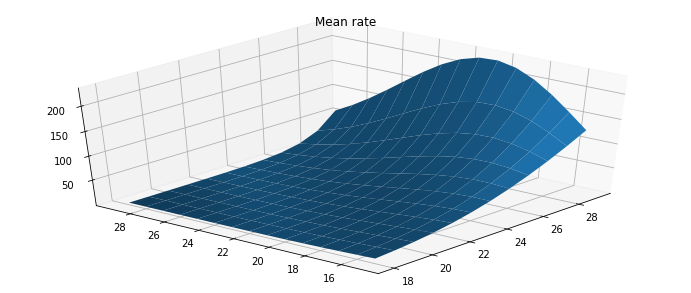

In [421]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(pred_piv.columns, pred_piv.index)
Z = pred_piv.values

surf = ax.plot_surface(X, Y, Z, linewidth=0, antialiased=True)
ax.view_init(elev=40., azim=-140)
ax.set_title("Mean rate")

## With Gaussian Process latent variable

In [20]:
with pm.Model() as gp_model:
    
    ro = pm.Exponential('ro', 1)
    eta = pm.Exponential('eta', 1)
    
    K = eta**2 + pm.gp.cov.ExpQuad(2, ro)
    gp = pm.gp.Latent(cov_func=K)
    latent = gp.prior('latent', X=data_mat[:,:2])

    likelihood = pm.Poisson('like', tt.exp(latent), observed=data_long['val'].values)

In [22]:
trace_gp = pm.sample(draws=1000, tune=1000, model=gp_model, target_accept=0.95, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [latent_rotated_, eta, ro]
Sampling 2 chains: 100%|██████████| 4000/4000 [25:47<00:00,  2.19draws/s]
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [27]:
data_long['gp_latent'] = np.exp(trace_gp['latent'].mean(axis=0))
data_long['gp_latent_sd'] = np.exp(trace_gp['latent'].std(axis=0))

In [30]:
gp_latent_data = data_long.pivot('r','m','gp_latent')
gp_latent_sd = data_long.pivot('r','m','gp_latent_sd')

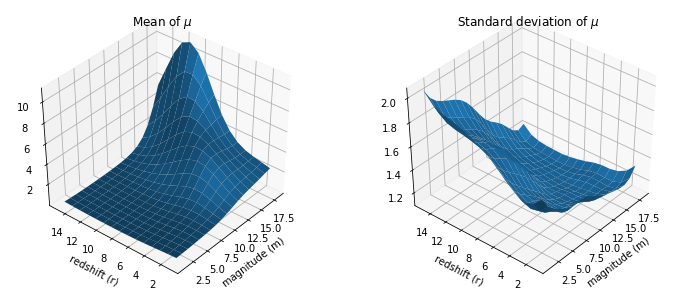

In [445]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121, projection='3d')
X, Y = np.meshgrid(gp_latent_data.columns, gp_latent_data.index)
Z = gp_latent_data.values

surf = ax.plot_surface(X, Y, Z, linewidth=0, antialiased=True)
ax.view_init(elev=40., azim=-140)
ax.set_title(r"Mean of $\mu$")
ax.set_xlabel("magnitude (m)")
ax.set_ylabel("redshift (r)")

ax2 = fig.add_subplot(122, projection='3d')
X, Y = np.meshgrid(gp_latent_sd.columns, gp_latent_sd.index)
Z = gp_latent_sd.values

surf = ax2.plot_surface(X, Y, Z, linewidth=0, antialiased=True)
ax2.view_init(elev=40., azim=-140)
ax2.set_title(r"Standard deviation of $\mu$",)
ax2.set_xlabel("magnitude (m)")
ax2.set_ylabel("redshift (r)")

plt.savefig("/Users/sidravinutala/Documents/Sid files/sidravi1.github.io/assets/2018_08_22_gp_model.png")

In [171]:
y_hats = pm.sample_ppc(trace_gp, model=gp_model)
lin_yhat_means = y_hats['like'].mean(axis=0)
data_long['gp_yhat_mean'] = lin_yhat_means

100%|██████████| 1000/1000 [00:06<00:00, 143.39it/s]


## Calculate goodness of fit - deviance residual

In [32]:
def deviance_resid(y, mu):
    def D(mu1, mu2):
        return  2 * mu1 * (((mu2/mu1) - 1) - np.log(mu2/mu1))
        
    return np.sign(y - mu) * np.sqrt(D(y, mu))
    

In [187]:
gp_dev = deviance_resid(data_long.val, data_long.gp_yhat_mean)**2
lin_dev = deviance_resid(data_long.val, data_long.linear_yhat_mean)**2

In [188]:
np.sum(gp_dev)

109.69225333767275

In [190]:
np.sum(lin_dev)

134.1491871074457

In [36]:
data_long['gp_dev'] = gp_dev
data_long['lin_dev'] = lin_dev 

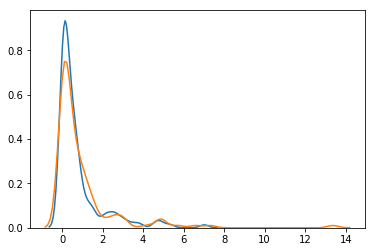

In [37]:
sns.kdeplot(gp_dev[~gp_dev.isna()])
sns.kdeplot(lin_dev[~lin_dev.isna()]);

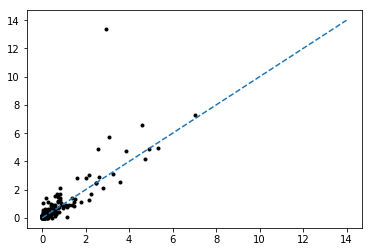

In [130]:
plt.plot(gp_dev, lin_dev, ".k")
#plt.loglog()
plt.plot([0,14], [0,14], ls= "--")

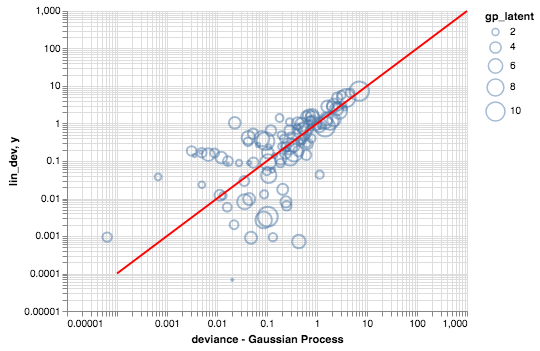

In [129]:
scatter = alt.Chart(data_long).mark_point(opacity=0.5).encode(
    x = alt.X('gp_dev',scale=alt.Scale(type='log')),
    y = alt.Y('lin_dev',scale=alt.Scale(type='log')),
    size = alt.Size('gp_latent', scale=alt.Scale(domain=[1.0, 10.0])),
    tooltip=['gp_latent', 'latent']
)

line = alt.Chart(pd.DataFrame([[0.0001,0.0001],[1000,1000]], columns = ['x','y'])).mark_line(style="--", color='red').encode(
    x = alt.X('x',scale=alt.Scale(type='log'), title='deviance - Gaussian Process'),
    y = alt.Y('y',scale=alt.Scale(type='log')),
)

scatter + line

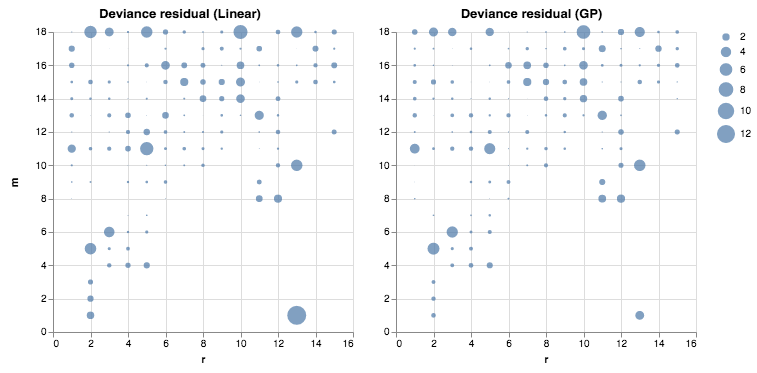

In [432]:
scatter_gp = alt.Chart(data_long, title="Deviance residual (GP)").mark_circle().encode(
    x = alt.X('r'),
    y = alt.Y('m', title=""),
    size=alt.Size('gp_dev', title=""),
    #size = alt.Size('gp_latent', scale=alt.Scale(domain=[1.0, 10.0])),
    tooltip=['gp_latent', 'linear_latent']
).properties(
    height = 300,
    width=300
)

scatter_lin = alt.Chart(data_long, title="Deviance residual (Linear)").mark_circle().encode(
    x = alt.X('r'),
    y = alt.Y('m'),
    size=alt.Size('lin_dev', title=""),
    tooltip=['gp_latent', 'linear_latent']
).properties(
    height = 300,
    width=300
)


scatter_lin | scatter_gp

In [434]:
df = pm.compare({gp_model:trace_gp, basic_model:trace}, )

/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


In [437]:
df.index = ['GP', 'Linear']

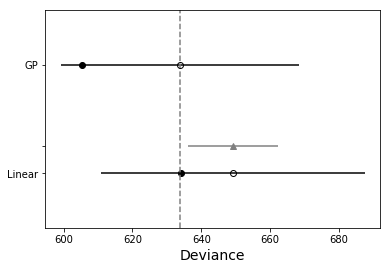

In [439]:
pm.compareplot(df)
plt.savefig("/Users/sidravinutala/Documents/Sid files/sidravi1.github.io/assets/2018_08_22_compare_plot.png", )